In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt

## Load the units

In [2]:
unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
unitT=u.Unit(unitbasis['time'])
unitV=u.Unit(unitbasis['velocity'])
unitD=u.Unit(unitbasis['distance'])
unitM=u.Unit(unitbasis['mass'])
unitG=u.Unit(unitbasis['G'])
G = const.G.to(unitG).value

## Load Galactic Parameters

In [3]:
MWparams = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe= tstrippy.Parsers.potential_parameters.MWreferenceframe()

## Add the bar parameters

In [21]:
# mass and size
abar = 4 * unitD
bbar = 1 * unitD
cbar = 0.5 * unitD
Mbar = 990.0*2.32*10e7 * unitM
barparams = [MWparams[0],Mbar.value,abar.value,bbar.value,cbar.value]
# oreitnation and bar pattern speed
theta0= 25 * (np.pi/180) 
omega =  28  * 2*np.pi * unitV / unitD
omega = omega.value
barpolycoeff=[theta0,omega]

## Reduce the mass of the disks
we are allocating it to the bar

In [22]:
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 

## Set integration time

Do this in years so that you can assure the number of timesteps is an integer, and then convert the total time *T* and the timestep *dt* into integration units.

In [23]:
T,dt = 1e9,1e6
Ntimestep=int(T/dt)
T,dt=T*u.yr,dt*u.yr
T,dt=T.to(unitT),dt.to(unitT)
t=np.arange(0,T.value,dt.value) # an array of time for later use

## Load the Globular Clusters
Store them in an astropy object to store them to galactocentric coordinates

In [24]:
GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
skycoordinates=coord.SkyCoord(
    ra=GCdata['RA'],
    dec=GCdata['DEC'],
    distance=GCdata['Rsun'],
    pm_ra_cosdec=GCdata['mualpha'],
    pm_dec=GCdata['mu_delta'],
    radial_velocity=GCdata['RV'],)
galacticcoordinates = skycoordinates.transform_to(MWrefframe)
x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
# grab the number of objects
Nobj=len(x)

## Initialize the integrator

In [25]:
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(x,y,z,vx,vy,vz)
tstrippy.integrator.setintegrationparameters(T.value,dt.value,Ntimestep)
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(Ntimestep,Nobj)
tstrippy.integrator.deallocate()

## Analyize the change in energy

In [26]:
E0 = np.zeros(Nobj)
_,_,_,phi0=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,0],yt[:,0],zt[:,0])
_,_,_,phiF=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,-1],yt[:,-1],zt[:,-1])
T0 = 0.5*(vxt[:,0]**2+vyt[:,0]**2+vzt[:,0]**2)
TF = 0.5*(vxt[:,-1]**2+vyt[:,-1]**2+vzt[:,-1]**2)

E0 = T0 + phi0
EF = TF + phiF
Lz0 = xt[:,0]*vyt[:,0]-yt[:,0]*vxt[:,0]
LzF = xt[:,-1]*vyt[:,-1]-yt[:,-1]*vxt[:,-1]

In [27]:
import matplotlib
colors = matplotlib.cm.rainbow(np.linspace(0,1,Nobj))

# make the font size bigger and also us Latex font
plt.rc('text', usetex=True)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)


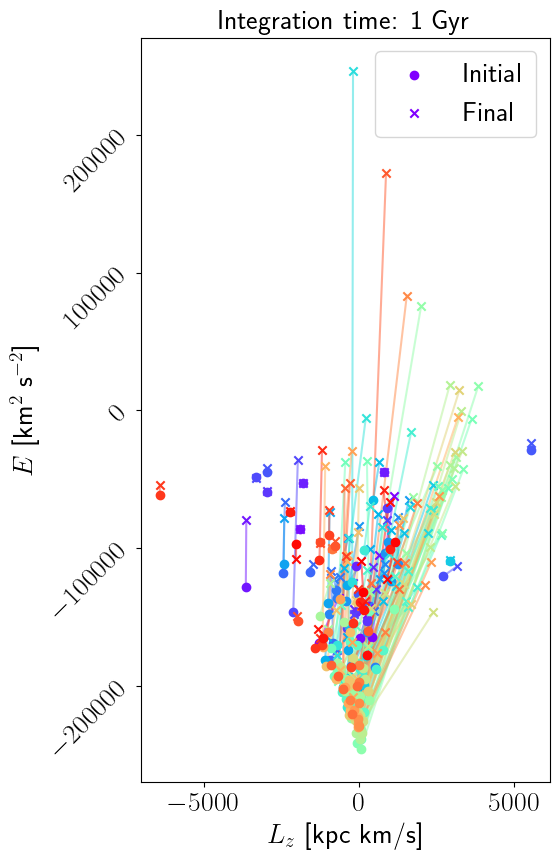

In [28]:
fig,axis=plt.subplots(1,1,figsize=(6,9))
AXIS = {
    "xlabel": r"$L_z$ [kpc km/s]",
    "ylabel": r"$E$ [km$^{2}$ s$^{-2}$]",
    "title": "Integration time: 1 Gyr",
}
for i in range(Nobj):
    if i ==0:
        axis.scatter(Lz0[i],E0[i],color=colors[i],label="Initial")
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x',label="Final")
    else:
        axis.scatter(Lz0[i],E0[i],color=colors[i])
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x')
    axis.plot([Lz0[i],LzF[i]],[E0[i],EF[i]],color=colors[i],alpha=0.5,zorder=0)
axis.set(**AXIS)
axis.tick_params(axis='y', rotation=45)
axis.legend()
fig.tight_layout()  